In [1]:
import jax

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_quark_gluon_dataloaders
from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer

data_dir = '/global/cfs/cdirs/m4392/salcc/data'

2023-08-22 03:36:06.518507: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-08-22 03:36:06.518531: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-08-22 03:36:06.518548: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-22 03:36:08.927539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Please first ``pip install -U cirq`` to enable related functionality in translation module


In [2]:
for d in jax.devices():
    print(d, d.device_kind)

gpu:0 NVIDIA A100-SXM4-40GB


(125, 125, 3)


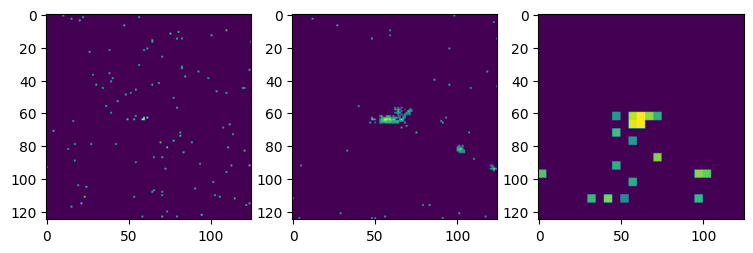

In [3]:
qg_train_dataloader, qg_valid_dataloader = get_quark_gluon_dataloaders(batch_size=256, data_dir=data_dir)
first_image = next(iter(qg_train_dataloader))[0][0]
print(first_image.shape)
plot_image(first_image, abs_log=True)

In [4]:
model = VisionTransformer(num_classes=2, patch_size=10, hidden_size=64, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=32, channels_last=True)
train_and_evaluate(model, qg_train_dataloader, qg_valid_dataloader, num_classes=2, learning_rate=0.0003, num_epochs=50)

Epoch  50/50: 100%|██████████| 544/544 [00:14<00:00, 38.35batch/s, Loss = 0.5320, AUC = 81.87%]

TOTAL TIME = 713.77s
BEST AUC = 82.04% AT EPOCH 49


In [5]:
model = VisionTransformer(num_classes=2, patch_size=10, hidden_size=6, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=3, channels_last=True)
train_and_evaluate(model, qg_train_dataloader, qg_valid_dataloader, num_classes=2, learning_rate=0.0003, num_epochs=50)

Epoch  50/50: 100%|██████████| 544/544 [00:13<00:00, 38.97batch/s, Loss = 0.5787, AUC = 77.48%]

TOTAL TIME = 683.22s
BEST AUC = 77.48% AT EPOCH 50
